In [35]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import activations

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
# for 2nd attempt
from keras.initializers import glorot_uniform
from keras.callbacks import EarlyStopping

import keras.backend as K

In [2]:
# let's choose a simple 1->1 function to train
def f(x):
    return 10*np.sin(10*x)+(x-3)*(x+2)*(x-1/2)+80*np.exp(-(x-2)**2/0.1)

In [3]:
# evaluate some data points
datasize = 5000
datapoints = np.random.uniform(low=-5, high=5, size=(datasize,))
datavalues = np.array(list(map(f, datapoints)))
data = np.transpose([datapoints,datavalues])
# instead of random.uniform one could have generated a set of sequential points
# using np.arange(-2,2,<step size>), does it affect the performance?

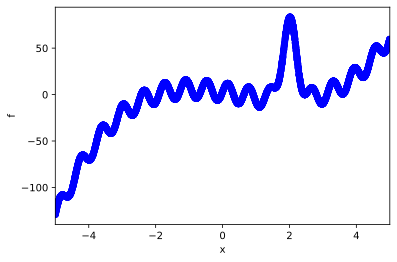

In [4]:
# plot the data points to see how they are distributed
plt.plot(datapoints, datavalues, 'bo')
plt.xlim([-5,5])
plt.ylabel('f')
plt.xlabel('x');

In [5]:
# use Mean Squared Error (MSE) for the loss function
def MSE(y_pred,y_true):
    return K.mean(K.square(y_pred - y_true))

In [6]:
## split into testing and training sets
print(len(data))
split = int(len(data)*80/100)

5000


In [7]:
# make sure all data is positive
def process_data(data):
    data_in_array = data[:,0]
    #data_in_ave = np.ave(data_in_array)
    #data_in_max = np.max(data_in_array)
    #data_in_min = np.min(data_in_array)
    #data_in_std = np.std(data_in_array)
    
    data_out_array = data[:,1]
    #data_out_ave = np.ave(data_out_array)
    data_out_max = np.max(data_out_array)
    data_out_min = np.min(data_out_array)
    #data_out_std = np.std(data_out_array)
    
    data_out_array = (data_out_array-data_out_min)/(data_out_max-data_out_min)
    
    data_processed = np.transpose([data_in_array,data_out_array])
    return data_processed, data_out_min, data_out_max

def unprocess_prediction(values, ymin, ymax):
    return values*(ymax-ymin) + ymin

In [8]:
### taken from stackoverflow
class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval
    
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 
                if epoch % self.epoch_interval != 0 
                else self.default_verbose
        )
        super().on_epoch_begin(epoch, *args, **kwargs)

In [26]:
# Initialise model
model = Sequential()
## input layer
model.add(Dense(1, input_dim=1))
model.add(Activation(activations.sigmoid))
## hidden layers
model.add(Dense(16))
model.add(Activation(activations.sigmoid))
# hidden layers
model.add(Dense(32))
model.add(Activation(activations.sigmoid))
# hidden layers
model.add(Dense(16))
model.add(Activation(activations.sigmoid))
## output layer
model.add(Dense(1))
model.add(Activation(activations.sigmoid))

# Compile model
model.compile(
    optimizer = Adam(lr=0.1, beta_1=0.9, beta_2=0.999, amsgrad=False),
    loss=MSE)

In [27]:
data_processed, ymin, ymax = process_data(data)
print(ymin, ymax)

-129.20844556364517 83.46666836940575


[ -3.176195   -30.09698313]
[-3.176195    0.46602285]


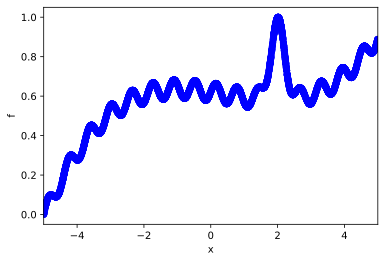

In [28]:
print(data[0])
print(data_processed[0])

plt.plot(data_processed[:,0], data_processed[:,1], 'bo')
plt.xlim([-5,5])
plt.ylabel('f')
plt.xlabel('x');

In [29]:
ES = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=100,
    verbose=0,
    restore_best_weights=True)

model.fit(
    data_processed[0:split,0],
    data_processed[0:split,1],
    epochs=3000,
    validation_data=(data_processed[split:,0], data_processed[split:,1]),
    callbacks=[SelectiveProgbarLogger(verbose = 1, epoch_interval = 300), ES],
    batch_size=512,
    verbose=0
)

Epoch 1/3000
4000/4000 [==============================] - 1s 228us/sample - loss: 0.0841 - val_loss: 0.0483
Epoch 301/3000
4000/4000 [==============================] - 0s 11us/sample - loss: 0.0058 - val_loss: 0.0055
Epoch 601/3000
4000/4000 [==============================] - 0s 10us/sample - loss: 0.0010 - val_loss: 9.9403e-04
Epoch 901/3000
4000/4000 [==============================] - 0s 11us/sample - loss: 7.5542e-04 - val_loss: 6.9740e-04


In [30]:
datapoints2 = np.random.uniform(low=-5, high=5, size=(1000,))
datavalues2 = np.array(list(map(f, datapoints2)))
valuespred = model.predict(datapoints2)

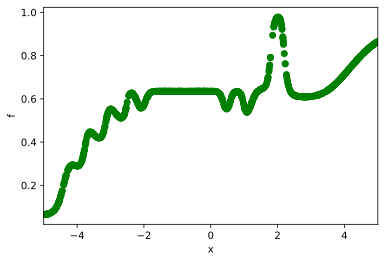

In [31]:
plt.plot(datapoints2, valuespred, 'go')
plt.xlim([-5,5])
plt.ylabel('f')
plt.xlabel('x');

In [32]:
valuespred_un = unprocess_prediction(valuespred, ymin, ymax)

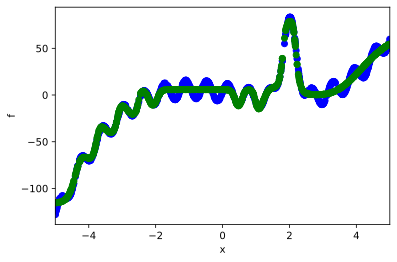

In [33]:
plt.plot(datapoints2, datavalues2, 'bo')
plt.plot(datapoints2, valuespred_un, 'go')
plt.xlim([-5,5])
plt.ylabel('f')
plt.xlabel('x');